#### Query Transformations Techniques

Query transformations are a set of approaches focused on re-writing and / or modifying questions for retrieval. Which will improve the performance of responses we get. Translate the question into a form, which is best suited for the retrival.

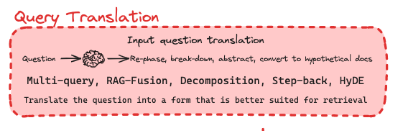

##### 1. Importing necessary packages and libraries and setting enviroment variables

In [1]:
import os
from dotenv import load_dotenv
from langchain_community.vectorstores import faiss
from langchain import hub
from langchain.prompts import ChatPromptTemplate
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [3]:
#### INDEXING ####

import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
vectorstore = FAISS.from_documents(documents=splits, 
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever()

C:\Users\admin\AppData\Local\Temp\ipykernel_19320\4106349506.py:34: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embeddings = HuggingFaceBgeEmbeddings(
c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Technique 1 : MultiQuery Prompting


























































































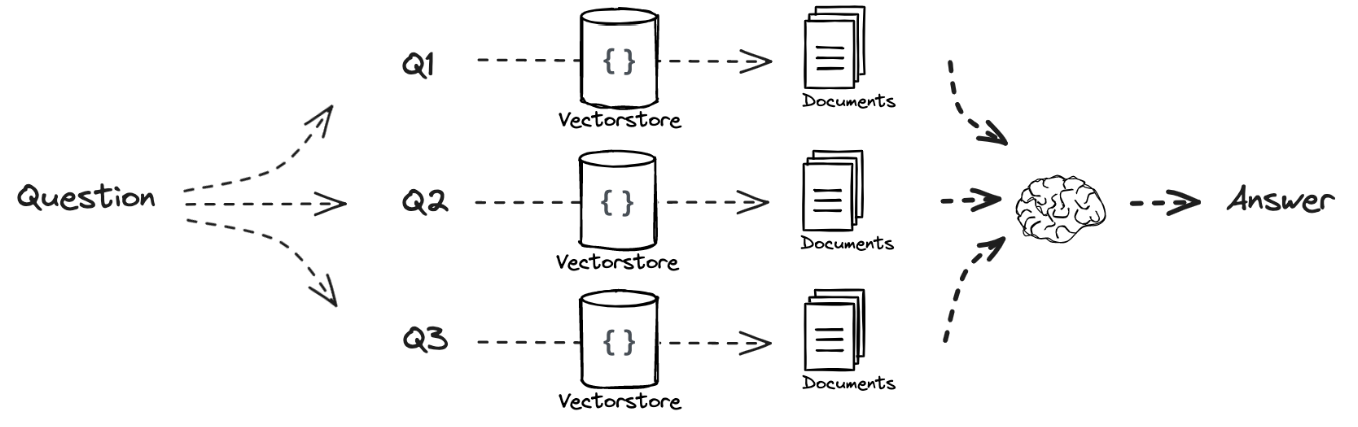

Transformed the question into multiple forms and provide it to the vectorstore to retrive documents base on that and then those documents passed to the LLM to get the better response.

In [4]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate three 
different versions of the given user question to retrieve relevant documents from a vector database. 
By generating multiple perspectives on the user question, your goal is to help 
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines and follow the below format to create the questions
Example : 
1. 'What is the definition and functionality of Artificial Intelligence, and how do intelligent agents operate?'
2. 'How do Artificial Intelligence systems and agents interact with their environment to achieve specific goals and tasks?'
3. 'What are the key concepts and techniques used in Artificial Intelligence to enable agents to perceive, reason, and act autonomously?'
Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

In [5]:
print(prompt_perspectives.invoke("How logistics business works ?").messages[0].content)

You are an AI language model assistant. Your task is to generate three 
different versions of the given user question to retrieve relevant documents from a vector database. 
By generating multiple perspectives on the user question, your goal is to help 
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines and follow the below format to create the questions
Example : 
1. 'What is the definition and functionality of Artificial Intelligence, and how do intelligent agents operate?'
2. 'How do Artificial Intelligence systems and agents interact with their environment to achieve specific goals and tasks?'
3. 'What are the key concepts and techniques used in Artificial Intelligence to enable agents to perceive, reason, and act autonomously?'
Original question: How logistics business works ?


In [6]:
generate_queries = (
    prompt_perspectives 
    | ChatGroq(model="llama-3.3-70b-versatile",temperature=0.5,max_retries=2)
    | StrOutputParser()
    | (lambda x:x.split("\n"))
)

generate_queries.invoke("How logistics business works ?")

["1. 'What are the fundamental principles and operations involved in the logistics industry, and how do companies manage the flow of goods and resources?'",
 "2. 'How do logistics businesses organize and coordinate the transportation, storage, and delivery of products to meet customer demands and achieve efficiency?'",
 "3. 'What are the key components, processes, and strategies used by logistics companies to ensure timely, cost-effective, and reliable supply chain management and distribution of goods?'"]

In [7]:
from langchain.load import dumps, loads
docs = retriever.invoke("What is task decomposition for LLM agents?")
[dumps(doc) for doc in docs]
    

['{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "document", "Document"], "kwargs": {"id": "797b0893-b0ec-4a30-824e-8927b8caac37", "metadata": {"source": "https://lilianweng.github.io/posts/2023-06-23-agent/"}, "page_content": "Fig. 1. Overview of a LLM-powered autonomous agent system.\\nComponent One: Planning#\\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\\nTask Decomposition#\\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to \\u201cthink step by step\\u201d to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model\\u2019s thinking process.\\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decom

In [8]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

C:\Users\admin\AppData\Local\Temp\ipykernel_19320\2784938305.py:10: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  return [loads(doc) for doc in unique_docs]


6

In [9]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate

In [10]:
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template=template)
llm_model = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.5,max_retries=2)
rag_chain = (
      {"context":retrieval_chain,"question":itemgetter("question")}
    | prompt
    | llm_model
    | StrOutputParser()
)

In [11]:
question

'What is task decomposition for LLM agents?'

In [12]:
#question : 'What is task decomposition for LLM agents?'
response = rag_chain.invoke({"question":question})
print(response)

Task decomposition for LLM (Large Language Model) agents refers to the process of breaking down complex tasks into smaller, more manageable subgoals or steps. This is a crucial component of a LLM-powered autonomous agent system, as it enables the agent to efficiently handle complex tasks.

Task decomposition can be achieved through various methods, including:

1. Chain of thought (CoT) prompting: This involves instructing the model to "think step by step" to utilize more test-time computation to decompose hard tasks into smaller and simpler steps.
2. Tree of Thoughts: This extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure.
3. Simple prompting: Using prompts like "Steps for XYZ" or "What are the subgoals for achieving XYZ?"
4. Task-specific instructions: Providing specific instructions for a task, such as "Write a story outline" for writing a novel.
5. Human inputs: Allowing humans to provide input and guidance on task decomposition.

By d

##### Technique 2 : RAG-Fusion (Rereanking of the queries)

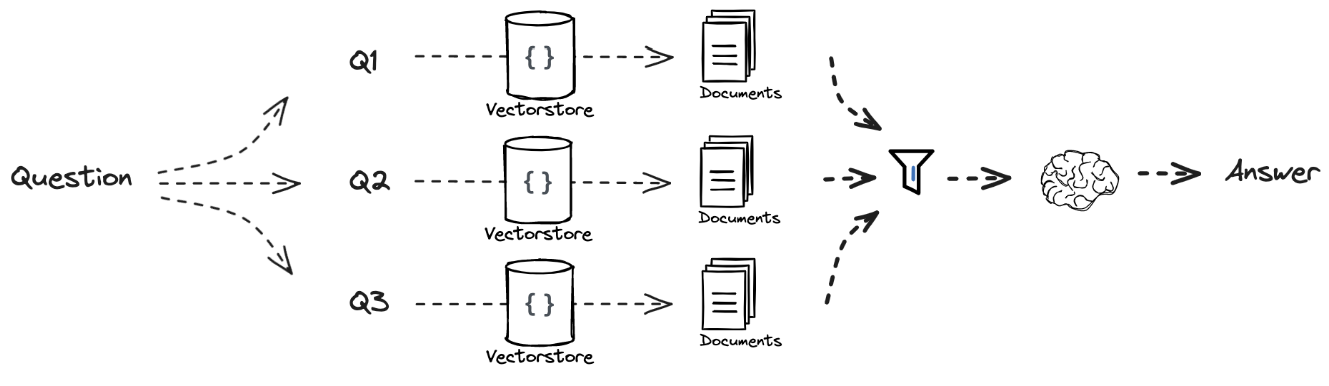

In Generative AI search systems, queries can be rephrased or expanded to capture different intents or contexts. RRF helps by merging results from these transformed queries.

Query Generation: A user query is reformulated into multiple variations using GenAI models (e.g., paraphrasing, synonym substitution, intent expansion).

Example: Original Query → "Best budget laptops"
Reformulation 1 → "Affordable laptops with good performance"
Reformulation 2 → "Top cheap laptops for students"
Result Retrieval: Each query variant retrieves a ranked list of results.

Fusion with RRF(Reciprocal Rank Fusion): RRF merges these rankings into a single list by rewarding documents consistently ranked well across multiple queries.

Final Ranking: The fused ranking is presented to the user, improving relevance and diversity.

In [13]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question}.\n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [14]:
prompt_rag_fusion

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='You are a helpful assistant that generates multiple search queries based on a single input query. \n\nGenerate multiple search queries related to: {question}.\n\nOutput (4 queries):'), additional_kwargs={})])

In [15]:
generate_queries = (
    prompt_rag_fusion 
    | ChatGroq(model="llama-3.3-70b-versatile",temperature=0.1,max_retries=2)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [16]:
generate_queries.invoke("What are the prices of laptops ?")

['Here are 4 search queries related to laptop prices:',
 '',
 '1. "Laptop price comparison online"',
 '2. "Best budget laptops with prices"',
 '3. "Latest laptop models and their prices"',
 '4. "Average cost of a laptop by brand and model"']

**k=60** is commonly used in research because it provides a good balance between favoring high-ranked results and giving lower-ranked results a fair chance.

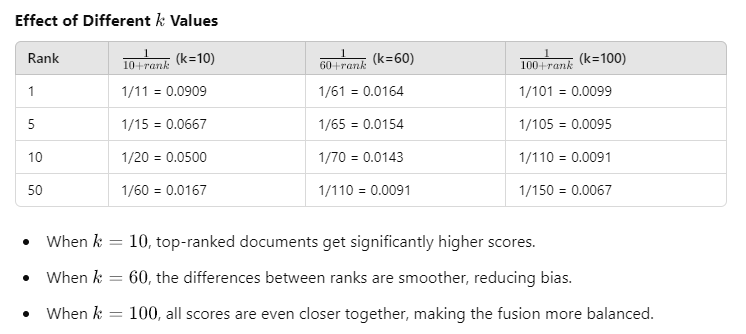

In [17]:
from langchain.load import loads,dumps
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
        
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

In [18]:
# generate_queries --> this chain will produce the inputs (queries)
# retriever.map() --> this will map the result with the inputs to get the outputs for each query
# reciprocal_rank_fusion --> this will rerank the documents based of RRF and return the documents
retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question":"What is task decomposition?"})

In [21]:
# docs

In [22]:
for i,doc in enumerate(docs):
    print(f"\n{i} \n",doc[0].page_content)


0 
 Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vo

itemgetter("question") is faster than lambda x:x["question"]

In [23]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
template = """
Answer the following question based on the following context : 
{context}

Question : {question}
"""

prompt_value = ChatPromptTemplate.from_template(template=template)
final_rag_chain = (
    {'context':retrieval_chain_rag_fusion,'question':itemgetter("question")}
    | prompt_value
    | ChatGroq(model="llama-3.3-70b-versatile",temperature=0.5,max_retries=2)
    | StrOutputParser()
)

question = "What is task decomposition ?"
response = final_rag_chain.invoke({"question":question})
print(response)

Task decomposition is the process of breaking down a complex task into smaller, more manageable tasks. This can be done using various techniques, such as:

1. Chain of Thought (CoT): This involves instructing a large language model (LLM) to "think step by step" to decompose a hard task into smaller and simpler steps.
2. Tree of Thoughts: This extends CoT by exploring multiple reasoning possibilities at each step, creating a tree structure.
3. Simple prompting: LLM can be prompted with simple questions like "Steps for XYZ" or "What are the subgoals for achieving XYZ?"
4. Task-specific instructions: Using specific instructions related to the task, such as "Write a story outline" for writing a novel.
5. Human inputs: Task decomposition can also be done with human inputs, where humans provide guidance on how to break down a complex task.

The goal of task decomposition is to transform big tasks into multiple manageable tasks, making it easier to understand and solve the problem.


##### Technique 3 : Decomposition

In [24]:
from langchain.prompts import ChatPromptTemplate
template = """
You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output should only contain the queries (3 Queries only) as shown in below example with no other information.
Example: 
1. Query1 \n
2. Query2 \n 
3. Query3 \n
"""

prompt_decomposition = ChatPromptTemplate.from_template(template=template)
prompt_decomposition

ChatPromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='\nYou are a helpful assistant that generates multiple sub-questions related to an input question. \n\nThe goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n\nGenerate multiple search queries related to: {question} \n\nOutput should only contain the queries (3 Queries only) as shown in below example with no other information.\nExample: \n1. Query1 \n\n2. Query2 \n \n3. Query3 \n\n'), additional_kwargs={})])

In [25]:
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

llm_model = ChatGroq(model="llama-3.3-70b-versatile",temperature=0,max_retries=2)

generate_queries = (
    prompt_decomposition
    | llm_model
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

questions = generate_queries.invoke({'question' : "What is task decomposition, explain me the Artificial Intelligence and how task decomposition is useful in this ?"})
print(questions)

['1. What is task decomposition in Artificial Intelligence and its applications?', '', '2. How does task decomposition improve problem-solving in AI systems?', '', '3. What are the benefits of using task decomposition in machine learning and natural language processing?']


- 3.1 : Answer Recursively

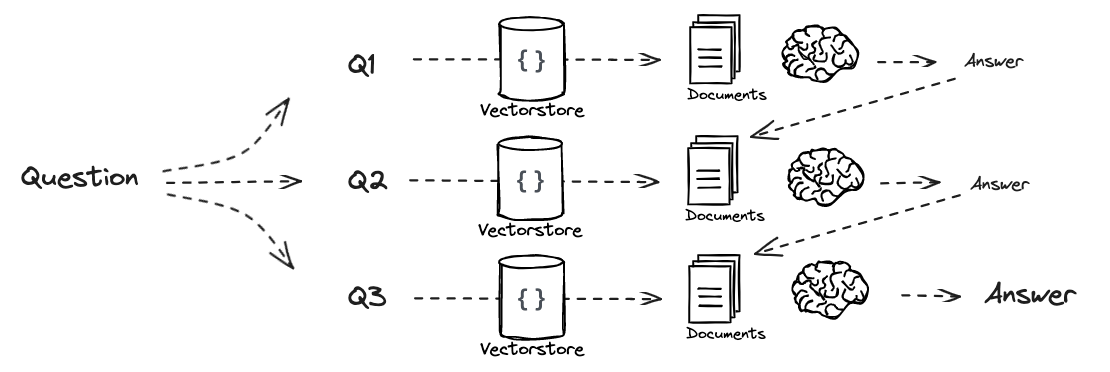

In [26]:
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [27]:
from operator import itemgetter
from langchain_groq import ChatGroq


llm_model = ChatGroq(model="llama-3.3-70b-versatile",temperature=0,max_retries=2)

def format_qa_pair(question,answer):
    formatted_string = ""
    formatted_string += f"Question : {question} \nAnswer : {answer} \n\n"
    return formatted_string.strip()

q_a_pairs = ""
for q in questions:
    decomposition_rag_chain = (
        {"context":itemgetter('question') | retriever,
         "question" : itemgetter('question'),
         "q_a_pairs" : itemgetter("q_a_pairs")}
        | decomposition_prompt
        | llm_model
        | StrOutputParser()
    )
    
    answer = decomposition_rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair =format_qa_pair(question,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [28]:
print(answer)

Task decomposition in machine learning and natural language processing has several benefits, including:

1. **Enhanced model performance**: By breaking down complex tasks into smaller, more manageable steps, models can focus on one step at a time, leading to improved performance on complex tasks.
2. **Improved reasoning and decision-making**: Task decomposition enables models to explore multiple reasoning possibilities at each step, creating a tree structure that sheds light on the model's thinking process.
3. **Autonomous planning and execution**: Task decomposition allows autonomous agents to plan and execute tasks by breaking them down into smaller, more manageable steps.
4. **Human-AI collaboration**: Task decomposition facilitates human-AI collaboration by enabling humans to provide input and guidance on the task decomposition process.
5. **Development of advanced AI systems**: Task decomposition supports the development of more advanced AI systems that can learn and adapt in comp

- 3.2 : Answer Individually

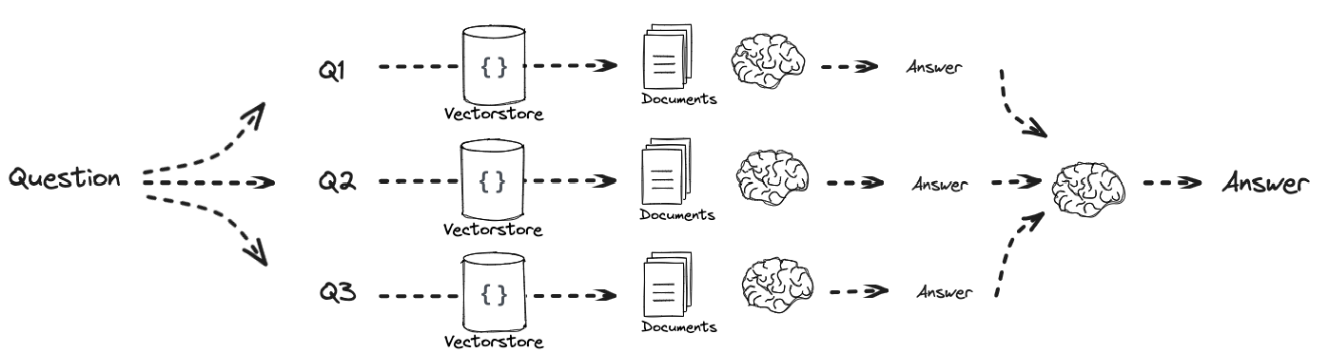

In [29]:
from langchain_core.runnables import RunnableLambda,RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from langchain import hub

In [30]:
prompt_rag = hub.pull("rlm/rag-prompt")
# input_variables --> context,question

In [35]:
prompt_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [32]:
# decomposition_prompts --> questions
# question --> LLM model
# LLM model --> answers
# combine answers --> LLM model
# LLM model --> final answer

In [34]:
# decomposed questions generations using llm model
question = "What is task decomposition and how it used in Artificial Intelligence ?"
questions = generate_queries.invoke(question)
questions 

['1. What is task decomposition in the context of Artificial Intelligence systems?',
 '2. How is task decomposition used to improve problem-solving in AI and machine learning?',
 '3. What are the benefits and challenges of implementing task decomposition in AI-powered applications?']

In [36]:
# getting answers for the decomposed questions and combining them in the Q-A pair as a list
rag_results = []

for ques in questions:
    retrieved_docs = retriever.get_relevant_documents(query=ques)
    answer_chain = (prompt_rag | llm_model | StrOutputParser())
    answer = answer_chain.invoke({"question":ques,"context":retrieved_docs})
    rag_results.append(f"Question : {ques} \nAnswer : {answer} \n\n")

C:\Users\admin\AppData\Local\Temp\ipykernel_19320\3160945693.py:5: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query=ques)


In [37]:
# passing the list of Q-A pair to the llm model to get the final answer
template = """
Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""
prompt_value = ChatPromptTemplate.from_template(template=template)

final_answer_chain = (
    prompt_value
    |llm_model
    |StrOutputParser()
)
# rag_results has the question and answer pairs
final_answer = final_answer_chain.invoke({"context":rag_results,"question":question})
print(final_answer)

Task decomposition in the context of Artificial Intelligence systems refers to the process of breaking down complex tasks into smaller, simpler steps. This can be achieved through various methods, including chain of thought (CoT) and tree of thoughts, which involve instructing the model to "think step by step" and explore multiple reasoning possibilities. Task decomposition is used to improve problem-solving in AI and machine learning by breaking down complex tasks into smaller, more manageable steps, allowing models to utilize more test-time computation and provide better performance on complex tasks. The benefits of task decomposition include enhanced model performance, improved problem-solving capabilities, and the ability to handle complex tasks. Overall, task decomposition is a powerful technique used in Artificial Intelligence to simplify complex tasks, improve model performance, and enhance overall problem-solving capabilities.


In [38]:
rag_results

['Question : 1. What is task decomposition in the context of Artificial Intelligence systems? \nAnswer : Task decomposition in the context of Artificial Intelligence systems refers to the process of breaking down complex tasks into smaller, simpler steps. This can be achieved through various methods, including chain of thought (CoT) and tree of thoughts, which involve instructing the model to "think step by step" and explore multiple reasoning possibilities. Task decomposition can be done using simple prompting, task-specific instructions, or human inputs. \n\n',
 'Question : 2. How is task decomposition used to improve problem-solving in AI and machine learning? \nAnswer : Task decomposition is used to improve problem-solving in AI and machine learning by breaking down complex tasks into smaller, more manageable steps. This can be achieved through techniques such as Chain of Thought (CoT) and Tree of Thoughts, which involve instructing the model to "think step by step" and explore mul

##### Technique 4 : Step-Back (Paraphrasing the queries)

In [39]:
from langchain_core.prompts import ChatPromptTemplate,FewShotChatMessagePromptTemplate


examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?"
    },
    {
        "input": "Jan Sindel's was born in what country?",
        "output": "what is Jan Sindel's personal history?",
    }
]
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human","{input}"),
        ("ai","{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples
    )

prompt = ChatPromptTemplate.from_messages(
    [
        ("system","""You are an expert at world knowledge. 
         Your task is to step back and paraphrase a question to a more generic step-back question, 
         which is easier to answer. Here are a few examples:"""),
        few_shot_prompt,
        ("user","{question}")
    ]
)

#prompt.invoke({"question":"What is task decomposition"})

In [40]:
generate_queries_step_back_chain = (
    prompt 
    | ChatGroq(temperature=0)
    | StrOutputParser()
)

# generate_queries_step_back_chain.invoke({"question":"What is task decomposition for LLM agents?"})

In [41]:
generate_queries_step_back_chain.invoke({"question":"What is task decomposition for LLM agents?"})

'how do LLM agents break down tasks?'

In [42]:
response_prompt_template = """You are an expert of world knowledge. 
I am going to ask you a question. Your response should be comprehensive and not contradicted with the 
following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt_value = ChatPromptTemplate.from_template(template=response_prompt_template)
# print(response_prompt_value)


final_answer_chain = (
    {
        "normal_context":RunnableLambda(lambda x:x["question"]) | retriever,
        "step_back_context":generate_queries_step_back_chain | retriever,
        "question":lambda x:x["question"],
    }
    | response_prompt_value
    | llm_model
    | StrOutputParser()
)
answer = final_answer_chain.invoke({"question":"What is task decomposition and how it is used in Artificial Intelligence ?"})
print(answer)

Task decomposition is a process in Artificial Intelligence (AI) where a complex task is broken down into smaller, more manageable sub-tasks or steps. This technique is used to enhance the performance of AI models, particularly Large Language Models (LLMs), on complex tasks.

Task decomposition can be achieved through various methods, including:

1. **Chain of Thought (CoT)**: This involves instructing the model to "think step by step" to decompose a hard task into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks, providing insight into the model's thinking process.
2. **Tree of Thoughts**: This extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be performed using breadth-first search (BFS) or depth-first search (DFS) with each state evaluated by a classifier or majority vote.
3. **S

##### Technique 5 : HyDE (Remaining)

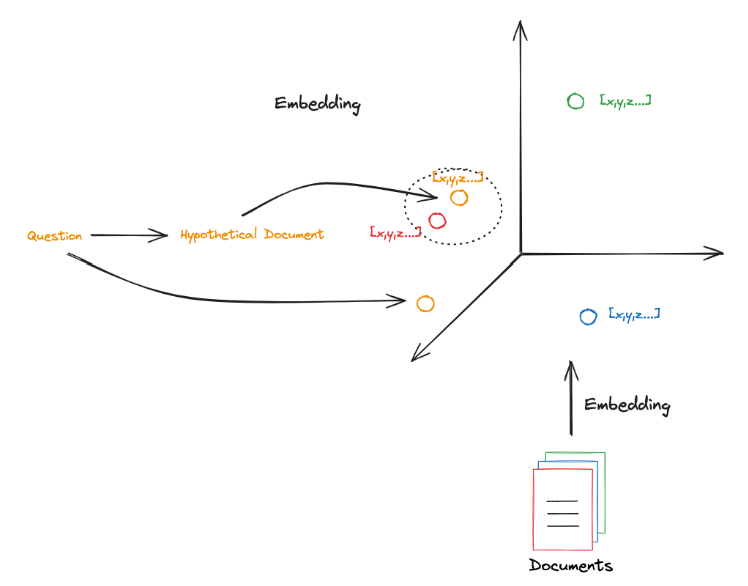